In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision 
from torchvision.models.detection import FasterRCNN
from torchvision.models.detection.rpn import AnchorGenerator
from torchvision import transforms


from torch.utils.data import Dataset, DataLoader

from tqdm.autonotebook import tqdm



import os
from imageio import imread
from glob import glob
import json

import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow

import pandas as pd

from sklearn.metrics import accuracy_score

import time

from idlmam import set_seed
from idlmam import train_network, Flatten, View, weight_reset, moveTo

In [2]:
%matplotlib inline
from IPython.display import set_matplotlib_formats
set_matplotlib_formats('png', 'pdf')

from IPython.display import display_pdf
from IPython.display import Latex

torch.backends.cudnn.deterministic=True
set_seed(42)

In [3]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu") 

In [5]:
#This URL has a copy of the dataset, make sure you go to Kaggle though and make an account and follow the license rules. 
data_url_zip = "https://github.com/kamalkraj/DATA-SCIENCE-BOWL-2018/blob/master/data/stage1_train.zip?raw=true"
from io import BytesIO
from zipfile import ZipFile
from urllib.request import urlopen
import re

#Download this dataset if we have not already done so
if not os.path.isdir('./data/stage1_train'):
    resp = urlopen(data_url_zip)
    os.mkdir("./data/stage1_train")
    zipfile = ZipFile(BytesIO(resp.read()))
    zipfile.extractall(path = './data/stage1_train')
#Grab all the paths to the images we just unziped 
paths = glob("./data/stage1_train/*")

In [6]:
class DSB2018(Dataset):
    """Dataset class for the 2018 Data Science Bowl."""
    def __init__(self, paths):
        """paths: a list of paths to every image folder in the dataset"""
        self.paths = paths
    
    def __len__(self):
        return len(self.paths)
    
    def __getitem__(self, idx):   
        #There is only one image in each images path. So we will grab the "first" thing we find with "[0]" at the end
        img_path = glob(self.paths[idx] + "/images/*")[0]        
        #but there are multiple mask images in each mask path
        mask_imgs = glob(self.paths[idx] + "/masks/*")        
        #the image shape is (W, H, 4), the last dimension is an 'alpha' channel that is not used
        img = imread(img_path)[:,:,0:3]#trim off the alpha so we get (W, H, 3)
        #Now we want this as (3, W, H), which is the normal shape for PyTorch
        img = np.moveaxis(img, -1, 0)
        #Last step for the image, re-scale it to the range [0, 1]
        img = img/255.0
       
        #Every mask image is going to have a shape of (W, H) which has a value of 1 if the pixel is of a nuclei, and a value of 0 if the image is background/ a  _different_ nuclei
        masks = [imread(f)/255.0 for f in mask_imgs]
        
        #Since we want to do simple segmentation, we will create one final mask that contains _all_ nuclei pixels from _every_ mask
        final_mask = np.zeros(masks[0].shape)
        for m in masks:
            final_mask = np.logical_or(final_mask, m)
        final_mask = final_mask.astype(np.float32)
        
        #Not every image in the dataset is the same size.  To simplify the problem, we are going to re-size  every image to be (256, 256)
        img, final_mask = torch.tensor(img), torch.tensor(final_mask).unsqueeze(0) #First we convert to PyTorch tensors
        #The interpolate function can be used to re-size a batch of images. So we make each image a "batch" of 1
        img = F.interpolate(img.unsqueeze(0), (256, 256))
        final_mask = F.interpolate(final_mask.unsqueeze(0), (256, 256))
        #Now the shapes  are (B=1, C, W, H) We need to convert them back to FloatTensors and grab the first item in the "batch". This will return a tuple of: (3, 256, 256), (1, 256, 256)
        return img.type(torch.FloatTensor)[0], final_mask.type(torch.FloatTensor)[0]
#Caption: Class for the 2018 data science bowl dataset.  Each image has a corresponding folder of masks, one for every object in the image. We aren’t going to do that kind of object detection yet. Instead our DataSet class will go through every mask and “or” them together, so that we get a single mask showing every pixel that contains an object. This is done inside __getitem__ which will return a tuple with the input image, followed by the mask we want to predict (i.e., all pixels that contain nuclei). 

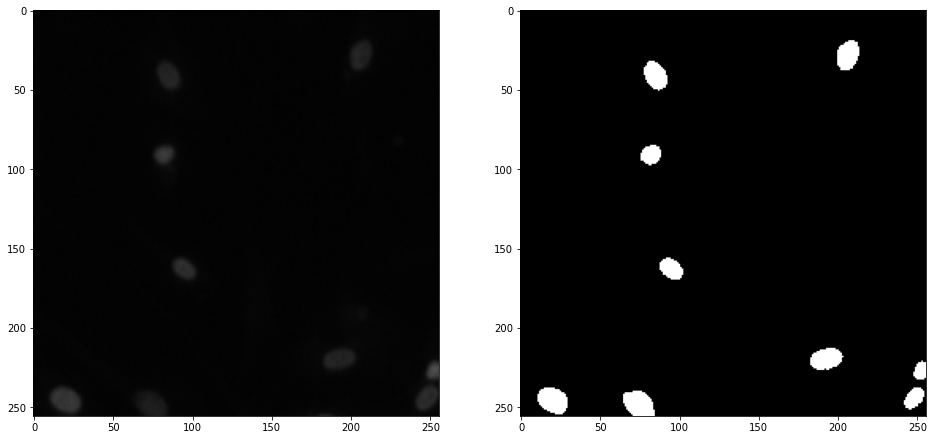

In [7]:
#Create the Dataset class object
dsb_data = DSB2018(paths)

plt.figure(figsize=(16,10))
#Plot the original image
plt.subplot(1, 2, 1)
plt.imshow(dsb_data[0][0].permute(1,2,0).numpy())
#Plot the mask
plt.subplot(1, 2, 2)
plt.imshow(dsb_data[0][1].numpy()[0,:], cmap='gray')

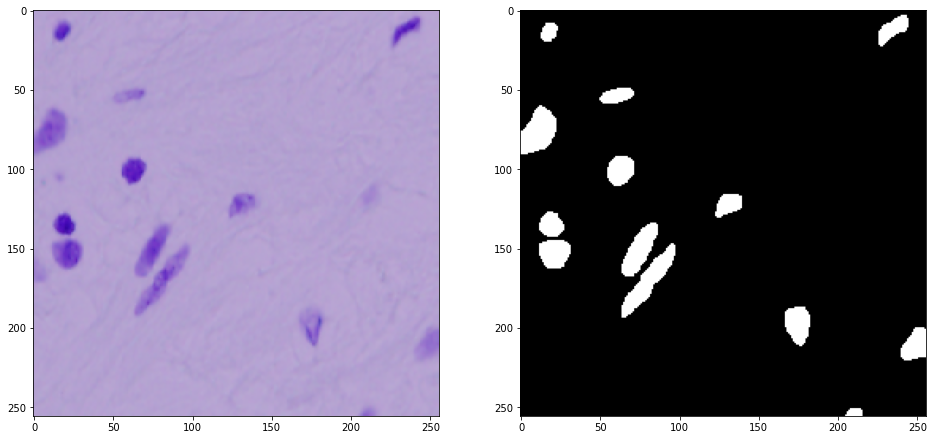

In [8]:
#Lets plot a second image that is in color
plt.figure(figsize=(16,10))
plt.subplot(1, 2, 1)
plt.imshow(dsb_data[1][0].permute(1,2,0).numpy())
plt.subplot(1, 2, 2)
plt.imshow(dsb_data[1][1].numpy()[0,:], cmap='gray')

In [9]:
train_split, test_split = torch.utils.data.random_split(dsb_data, [500, len(dsb_data)-500])
train_seg_loader = DataLoader(train_split, batch_size=16, shuffle=True)
test_seg_loader = DataLoader(test_split,  batch_size=16)

In [10]:
C = 3 #How many channels are in the input? 
n_filters = 32 #Smallest value of filters you should usually consider. If we wanted to try and optimize the architecture we could use Optuna to pick a better number of filters. 
loss_func = nn.BCEWithLogitsLoss()#BCE loss implicitly assumes a binary problem

In [11]:
#Define our helper function that creates a hidden layer for a CNN
def cnnLayer(in_filters, out_filters, kernel_size=3):
    """
    in_filters: how many channels are in the input to this layer
    out_filters: how many channels should this layer output
    kernel_size: how large should the filters of this layer be
    """
    padding = kernel_size//2
    return nn.Sequential(
        nn.Conv2d(in_filters, out_filters, kernel_size, padding=padding), 
        nn.BatchNorm2d(out_filters),
        nn.LeakyReLU(), # I'm not setting the leak value to anything just to make the code shorter. 
    )
#Specifying a model for image segmentation
segmentation_model = nn.Sequential(
    cnnLayer(C, n_filters), #First layer changes number of channels up to the large numer
    *[cnnLayer(n_filters, n_filters) for _ in range(5)], #Create 5 more hidden layers
    #Make a prediction for _every_ location. Notice we use 1 channel out, since we have a binary problem and are using BCEWithLogitsLoss as our loss function. 
    nn.Conv2d(n_filters, 1, (3,3), padding=1), #Shape is now (1, W, H)
)
#train the segmentation model
seg_results = train_network(segmentation_model, loss_func, train_seg_loader, epochs=10, device=device, val_loader=test_seg_loader)

Text(-240, -50, 'Error: Phantom object')

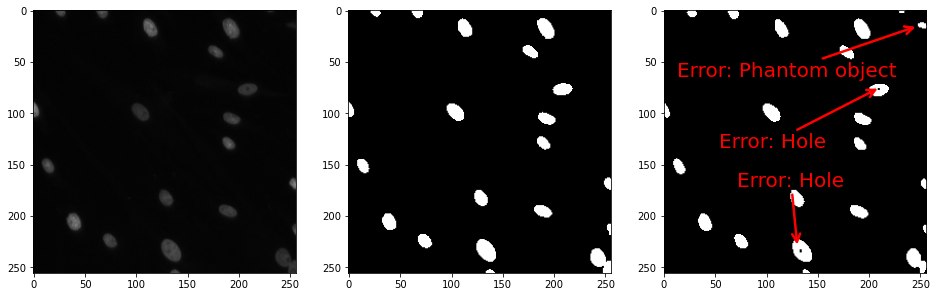

In [12]:
index = 6 # Picking a specific example from the dataset that shows a particular result. Change this to look at other entries from the dataset.

with torch.no_grad():#We don't want gradients if we aren't training, so no gradients please!
    #push a test datapoint through the model. Remember the raw outputs are called the logits
    logits = segmentation_model(test_split[index][0].unsqueeze(0).to(device))[0].cpu()
    #apply $\sigma$ to the logits to make predictions and then apply a threshold to get a prediction mask
    pred = torch.sigmoid(logits) >= 0.5

#Plot the input, ground truth, and prediction
plt.figure(figsize=(16,10))
plt.subplot(1, 3, 1)
plt.imshow(test_split[index][0].permute(1,2,0).numpy(), cmap='gray') #First plot the original input to the network
plt.subplot(1, 3, 2)
plt.imshow(test_split[index][1].numpy()[0,:], cmap='gray') #Second is ground truth
plt.subplot(1, 3, 3) 
plt.imshow(pred.numpy()[0,:], cmap='gray') #Third is the prediction our network made

plt.annotate('Error: Hole', color="red", fontsize=20, xy=(130, 230),
            xycoords='data', xytext=(-60, 60),
            textcoords='offset points',
            arrowprops=dict(arrowstyle="->",
                            linewidth = 2.5,
                            color = 'red')
            )

plt.annotate('Error: Hole', color="red", fontsize=20, xy=(210, 75),
            xycoords='data', xytext=(-160, -60),
            textcoords='offset points',
            arrowprops=dict(arrowstyle="->",
                            linewidth = 2.5,
                            color = 'red')
            )
plt.annotate('Error: Phantom object', color="red", fontsize=20, xy=(247, 15),
            xycoords='data', xytext=(-240, -50),
            textcoords='offset points',
            arrowprops=dict(arrowstyle="->",
                            linewidth = 2.5,
                            color = 'red')
            )

In [14]:
segmentation_model2 = nn.Sequential(
    cnnLayer(C, n_filters), #First layer changes number of channels up to the large numer
    cnnLayer(n_filters, n_filters),
    nn.MaxPool2d(2), #Shrinks the height and width by 2
    cnnLayer(n_filters, 2*n_filters),
    cnnLayer(2*n_filters, 2*n_filters),
    cnnLayer(2*n_filters, 2*n_filters),
    #Double the height and width, countering the effect of the single MaxPool2d before
    nn.ConvTranspose2d(2*n_filters, n_filters, (3,3), padding=1, output_padding=1, stride=2),
    nn.BatchNorm2d(n_filters),
    nn.LeakyReLU(),
    #Back to normal convolutions
    cnnLayer(n_filters, n_filters),
    #Prediction for _every_ location
    nn.Conv2d(n_filters, 1, (3,3), padding=1), #Shape is now (B, 1, W, H)
)

seg_results2 = train_network(segmentation_model2, loss_func, train_seg_loader, epochs=10, device=device, val_loader=test_seg_loader)

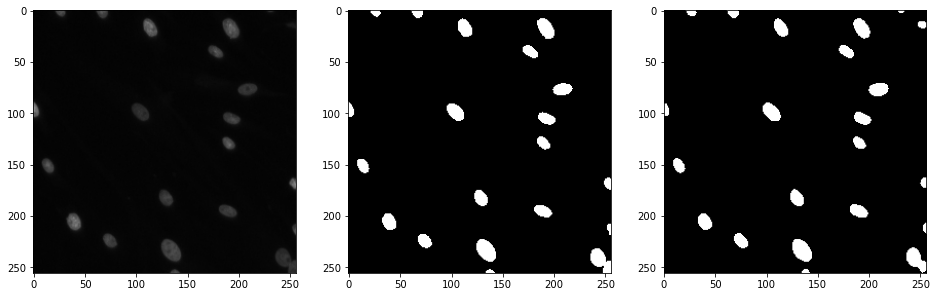

In [15]:
index = 6 # Same example from before

with torch.no_grad(): #We don't want gradients if we aren't training, so no gradients please!
    #push a test datapoint through the model. Remember the raw outputs are called the logits
    pred = segmentation_model2(test_split[index][0].unsqueeze(0).to(device))[0].cpu()
    #apply $\sigma$ to the logits to make predictions and then apply a threshold to get a prediction mask
    pred = torch.sigmoid(pred) >= 0.5


#Plot the input, ground truth, and prediction
plt.figure(figsize=(16,10))
plt.subplot(1, 3, 1)
plt.imshow(test_split[index][0].permute(1,2,0).numpy(), cmap='gray')  #First plot the original input to the network
plt.subplot(1, 3, 2)
plt.imshow(test_split[index][1].numpy()[0,:], cmap='gray') #Second is ground truth
plt.subplot(1, 3, 3)
plt.imshow(pred.numpy()[0,:], cmap='gray') #Third is the prediction our network made

In [16]:
del segmentation_model
del segmentation_model2

<AxesSubplot:xlabel='epoch', ylabel='val loss'>

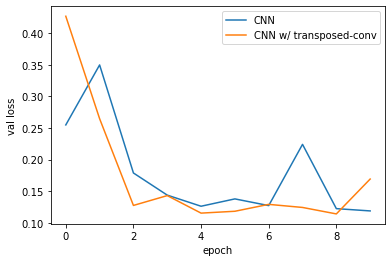

In [17]:
sns.lineplot(x='epoch', y='val loss', data=seg_results, label='CNN')
sns.lineplot(x='epoch', y='val loss', data=seg_results2, label='CNN w/ transposed-conv')

In [18]:
class UNetBlock2d(nn.Module): #Our class extends nn.Module, all PyTorch layers must extend this 
    def __init__(self, in_channels, mid_channels, out_channels=None, layers=1, sub_network=None, filter_size=3):
        """ 
        in_channels: the number of channels in the input to this block
        mid_channels: the number of channels to have as the output for each convolutional filter
        out_channels: if not `None`, ends the network with a 1x1 convolution to convert the number of output channels to a specific number. 
        layers: how many blocks of hidden layers to create on both the input and output side of a U-Net block
        sub_network: the network to apply after shrinking the input by a factor of 2 using max pooling. The number of output channels should be equal to `mid_channels`
        filter_size: how large the convolutional filters should be
        """
        super().__init__()
        
        #Start preparing the layers used to process the input
        in_layers = [cnnLayer(in_channels, mid_channels, filter_size)]
        
        #If we have a sub-network, we will double the number of inputs to the output. So lets figure that out now
        if sub_network is None:
            inputs_to_outputs = 1
        else:
            inputs_to_outputs = 2

        #Preparing the layers used to make the final output, which has extra input channels from any sub-network
        out_layers = [ cnnLayer(mid_channels*inputs_to_outputs, mid_channels, filter_size)]
        
        #Make the additional hidden layers used for the input and output
        for _ in range(layers-1):
            in_layers.append(cnnLayer(mid_channels, mid_channels, filter_size))
            out_layers.append(cnnLayer(mid_channels, mid_channels, filter_size))
        #Use 1x1 Convolutions to ensure a specific output size
        if out_channels is not None:
            out_layers.append(nn.Conv2d(mid_channels, out_channels, 1, padding=0))
    
        #define our three total sub-networks:
        #1) in_model performs the intial rounds of convolution
        self.in_model = nn.Sequential(*in_layers)
        #2) our subnetwork works on the max-pooled result. We will add the pooling and up-scaling directly into the sub-model
        if sub_network is not None:
            self.bottleneck = nn.Sequential(
                nn.MaxPool2d(2), #Shrink
                sub_network, #process the smaller resolution
                #expand back up
                nn.ConvTranspose2d(mid_channels, mid_channels, filter_size, padding=filter_size//2, output_padding=1, stride=2)
            )
        else:
            self.bottleneck = None
        #3) the output model that processes the concatinated result, or just the output from in_model if no sub-network was given
        self.out_model = nn.Sequential(*out_layers)
        
    
    #The forward function is the code that takes an input and produce an output. 
    def forward(self, x):
        #compute the convolutions at the current scale
        full_scale_result = self.in_model(x) #(B, C, W, H)
        #check if we have a bottleneck to apply
        if self.bottleneck is not None:
            #(B, C, W, H) shape because bottleneck does both the pooling & expansion
            bottle_result = self.bottleneck(full_scale_result)
            #Now shape (B, 2*C, W, H)
            full_scale_result = torch.cat([full_scale_result, bottle_result], dim=1)
        #compute the output on the concatenated (or not!) result
        return self.out_model(full_scale_result)
#Caption: A class implementing a “Block” of the U-Net approach. Each block needs to know how many channels are coming in and out of the block. The block has three components. 1) the input network, what processes the raw input coming into this block. 2) the bottleneck, which is what the block runs after shrinking the current results down by a factor of 2, and then expands the result back up to the original size. 3) the output network, which is run on the results from the prior two sub-networks concatenated together. 

In [19]:
unet_model = nn.Sequential(
    UNetBlock2d(3, 32, layers=2, sub_network=
        UNetBlock2d(32, 64, out_channels=32, layers=2, sub_network=
            UNetBlock2d(64, 128, out_channels=64, layers=2)
        ),
    ),
    #Prediction for _every_ location
    nn.Conv2d(32, 1, (3,3), padding=1), #Shape is now (B, 1, W, H)
)

unet_results = train_network(unet_model, loss_func, train_seg_loader, epochs=10, device=device, val_loader=test_seg_loader)

<AxesSubplot:xlabel='epoch', ylabel='val loss'>

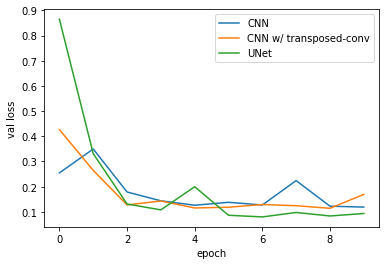

In [20]:
sns.lineplot(x='epoch', y='val loss', data=seg_results, label='CNN')
sns.lineplot(x='epoch', y='val loss', data=seg_results2, label='CNN w/ transposed-conv')
sns.lineplot(x='epoch', y='val loss', data=unet_results, label='UNet')

In [21]:
set_seed(42)

In [22]:
class Class2Detect(Dataset):
    """This class is used to create a simple converstion of a dataset from a classification problem, to a detection problem. """

    def __init__(self, dataset, toSample=3, canvas_size=100):
        """
        dataset: the source dataset to sample items from as the "objects" to detect
        toSample: the maximum number of "objects" to put into any image
        canvas_size: the width and height of the images to place objects inside of. 
        """
        self.dataset = dataset
        self.toSample = toSample
        self.canvas_size = canvas_size

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        
        boxes = []
        labels = []
        
        final_size = self.canvas_size
        #First, create a larger image that will store all the "objects" to detect
        img_p = torch.zeros((final_size,final_size), dtype=torch.float32)
        #Now we are going to sample up to self.toSample objects to place into the image
        for _ in range(np.random.randint(1,self.toSample+1)):
            
            #Pick an object at random from the original dataset, and its label
            img, label = self.dataset[np.random.randint(0,len(self.dataset))]
            #Get the height and width of that image
            _, img_h, img_w = img.shape
            #Pick a random offset of the x and y axis, essentially placing the image at a random location
            offsets = np.random.randint(0,final_size-np.max(img.shape),size=(4))
            #Change the padding at the end to make sure we come out to a specific 100,100 shape
            offsets[1] = final_size - img.shape[1] - offsets[0]
            offsets[3] = final_size - img.shape[2] - offsets[2]
            
            with torch.no_grad():
                img_p = img_p + F.pad(img, tuple(offsets))
            #Lets craete the values for the "boxes"
            #all of these are in absolute pixel locations
            
            #x_min determined by the randomly selected offset
            xmin = offsets[0]
            #x_max is the offset plus the image's width
            xmax = offsets[0]+img_w
            #y min/max follows the same pattern
            ymin = offsets[2]
            ymax = offsets[2]+img_h
            #now we add to the box with the right label
            boxes.append( [xmin, ymin, xmax, ymax] )
            labels.append( label )

            
        target = {}
        target["boxes"] = torch.as_tensor(boxes, dtype=torch.float32)
        target["labels"] = torch.as_tensor(labels, dtype=torch.int64)
        
        return img_p, target
#Caption: This class defines a toy MNIST detector. Images from the MNIST dataset are placed at random locations in an image. The object detector will try to learn to predict where digits are, and what digit is at each location. 

In [23]:
train_data = Class2Detect(torchvision.datasets.MNIST("./", train=True, transform=transforms.ToTensor(), download=True))
test_data = Class2Detect(torchvision.datasets.MNIST("./", train=False, transform=transforms.ToTensor(), download=True))

def collate_fn(batch):
    """
    batch is going to contain a python list of objects. In our case, our data loader returns (Tensor, Dict) pairs
    The FasterRCNN algorithm wants a List[Tensors] and a List[Dict]. So we will use this function to convert the 
    batch of data into the form we want, and then give it to the Dataloader to use
    """
    imgs = []
    labels = []
    for img, label in batch:
        imgs.append(img)
        labels.append(label)
    return imgs, labels

train_loader = DataLoader(train_data, batch_size=128, shuffle=True, collate_fn=collate_fn)

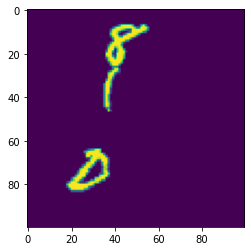

In [24]:
x, y = train_data[0] # Grab an image with its labels
imshow(x.numpy()[0,:])

In [25]:
print(y) #prints out everything
print("Boxes: ", y['boxes']) #prints a tensor showing the pixel locations of the corners for all 3 objects
print("Labels: ", y['labels']) #prints a tensor showing the labels for all 3 objects

{'boxes': tensor([[14., 60., 42., 88.],
        [23., 21., 51., 49.],
        [29.,  1., 57., 29.]]), 'labels': tensor([0, 1, 8])}
Boxes:  tensor([[14., 60., 42., 88.],
        [23., 21., 51., 49.],
        [29.,  1., 57., 29.]])
Labels:  tensor([0, 1, 8])


In [26]:
#How many channels are in the input?
C = 1
#How many classes are there?
classes = 10
#How many filters in our backbone
n_filters = 32

In [27]:
backbone = nn.Sequential(
    cnnLayer(C, n_filters),    
    cnnLayer(n_filters, n_filters),
    cnnLayer(n_filters, n_filters),
    nn.MaxPool2d((2,2)),
    cnnLayer(n_filters, 2*n_filters),
    cnnLayer(2*n_filters, 2*n_filters),
    cnnLayer(2*n_filters, 2*n_filters),
    nn.MaxPool2d((2,2)),
    cnnLayer(2*n_filters, 4*n_filters),
    cnnLayer(4*n_filters, 4*n_filters),
)
#Let Faster RCNN know exactly how many output channels to expect
backbone.out_channels = n_filters*4

In [28]:
# How many proposals $k$ should be generated? Every aspect ration will be one, and the process will be repeated for multiple image sizes 
anchor_generator = AnchorGenerator(sizes=((32),), aspect_ratios=((1.0),)) #To make this run faster, we are telling PyTorch to look for only square images that are 32 x 32 in size

#Tell PyTorch to use the final output of the backbone as the featuremap (['0']), use adaptive pooling down to a 7x7 grid (output_size=7)
roi_pooler = torchvision.ops.MultiScaleRoIAlign(featmap_names=['0'], output_size=7, sampling_ratio=2)
#sampling_ratio is poorly named, and controls details on how the RoI grabs slices of the feature map when a fractional pixel location is predicted (e.g., 5.8 instead of 6). We are not going to go into those low level details, 2 is a reasonable default for most work. 
        
#Now we can create the FasterRCNN object. We give it the backbone network, number of classes, min & max size to process images at (we know all our images at 100 pixels), a mean and standard deviation to subtract from the images, and the anchor generation (RPN) and RoI objects
model = FasterRCNN(backbone, num_classes=10, image_mean = [0.5], image_std = [0.229], min_size=100, max_size=100, rpn_anchor_generator=anchor_generator, box_roi_pool=roi_pooler)

In [29]:
model = model.train()
model.to(device)
optimizer = torch.optim.AdamW(model.parameters())

for epoch in tqdm(range(1), desc="Epoch", disable=False):
    running_loss = 0.0
    for inputs, labels in tqdm(train_loader, desc="Train Batch", leave=False, disable=False):
        #Move the batch to the device we are using. 
        inputs = moveTo(inputs, device)
        labels = moveTo(labels, device)

        optimizer.zero_grad()
        #rcnn wants model(inputs, labels) - not just model(inputs)
        losses = model(inputs, labels)
        # Compute loss, RCNN gives us a list of losses to add up.
        loss = 0
        for partial_loss in losses.values():
            loss += partial_loss
        #now proceed like normal
        loss.backward()
        
        optimizer.step()

        running_loss += loss.item()

In [30]:
model = model.eval()
model = model.to(device)

In [31]:
set_seed(161)

In [32]:
x, y = test_data[0]
print(y) #this is the ideal truth we want to get back

{'boxes': tensor([[31., 65., 59., 93.],
        [10., 36., 38., 64.],
        [64., 24., 92., 52.]]), 'labels': tensor([8, 0, 4])}


In [33]:
with torch.no_grad():
    pred = model([x.to(device)])

In [34]:
print(pred)

[{'boxes': tensor([[31.9313, 65.4917, 59.7824, 93.3052],
        [64.1321, 23.8941, 92.0808, 51.8841],
        [70.3358, 26.2407, 96.2834, 53.7900],
        [64.9917, 24.2980, 92.9516, 52.2016],
        [30.9127, 65.1308, 58.6978, 93.3224]], device='cuda:0'), 'labels': tensor([8, 4, 1, 9, 5], device='cuda:0'), 'scores': tensor([0.9896, 0.9868, 0.1201, 0.0699, 0.0555], device='cuda:0')}]


In [35]:
import matplotlib.patches as patches

In [36]:
def plotDetection(ax, abs_pos, label=None):
    """
    ax: the matpllib axis to add this plot to
    abs_pos: the positions of the bounding box
    label: the label of the prediction to add
    """
    x1, y1, x2, y2 = abs_pos
    #make a rectangle for the bounding box
    rect = patches.Rectangle((x1,y1),x2-x1,y2-y1,linewidth=1,edgecolor='r',facecolor='none')
    ax.add_patch(rect)
    #add the label if given
    if label is not None:
        plt.text(x1+0.5, y1, label, color='black', bbox=dict(facecolor='white', edgecolor='white', pad=1.0))
    
    return 

def showPreds(img, pred):
    """
    img: the image to show the bounding box predictions for
    pred: the Faster R-CNN predictions to show ontop of the image
    """
    fig,ax = plt.subplots(1)
    #plot the image
    ax.imshow(img.cpu().numpy()[0,:])
    #grab the predictions
    boxes = pred['boxes'].cpu()
    labels = pred['labels'].cpu()
    scores = pred['scores'].cpu()
    
    num_preds = labels.shape[0]
    #for each prediction, plot if if it has a high enough score
    for i in range(num_preds):
        plotDetection(ax, boxes[i].cpu().numpy(), label=str(labels[i].item()))
    
    plt.show()

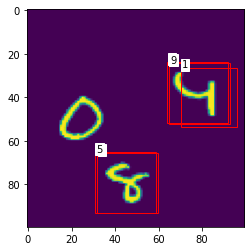

In [37]:
showPreds(x, pred[0])

In [38]:
from torchvision.ops import nms

In [39]:
print(pred[0]['boxes'])

tensor([[31.9313, 65.4917, 59.7824, 93.3052],
        [64.1321, 23.8941, 92.0808, 51.8841],
        [70.3358, 26.2407, 96.2834, 53.7900],
        [64.9917, 24.2980, 92.9516, 52.2016],
        [30.9127, 65.1308, 58.6978, 93.3224]], device='cuda:0')


In [40]:
print(pred[0]['scores'])

tensor([0.9896, 0.9868, 0.1201, 0.0699, 0.0555], device='cuda:0')


In [41]:
print(nms(pred[0]['boxes'], pred[0]['scores'], 0.5))

tensor([0, 1], device='cuda:0')


In [42]:
def showPreds(img, pred, iou_max_overlap=0.5, min_score=0.05, label_names=None):
    """
    img: the original image object detection was performed on
    pred: the output dictionary from FasterRCNN for evaluation on img
    iou_max_overlap: the iou threshold at which non-maximum suppression will be performed
    min_score: the minimum RPN network score to consider an object
    """
    fig,ax = plt.subplots(1)
    img = img.cpu().numpy()
    if img.shape[0] == 1:
        ax.imshow(img[0,:])
    else:
        ax.imshow(np.moveaxis(img, 0, 2))
    boxes = pred['boxes'].cpu()
    labels = pred['labels'].cpu()
    scores = pred['scores'].cpu()
    
    selected = nms(boxes, scores, iou_max_overlap).cpu().numpy()
    
    for i in selected:
        if scores[i].item() > min_score:
            if label_names is None:
                label = str(labels[i].item())
            else:
                label = label_names[labels[i].item()]
            plotDetection(ax, boxes[i].cpu().numpy(), label=label)
    
    plt.show()

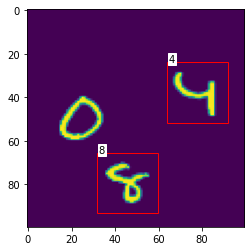

In [43]:
showPreds(x, pred[0])

In [44]:
rcnn = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)
# This RCNN detector is pre setup for a specific set of classes. You can re-use it for your own problems by setting num_classes=10 and pretrained_backbone=True, and then training it with your own data like we did before with MNIST. 

In [45]:
rcnn = rcnn.eval()

In [46]:
# COCO_INSTANCE_CATEGORY_NAMES, these come from the PyTorch documentation. https://pytorch.org/docs/stable/torchvision/models.html#object-detection-instance-segmentation-and-person-keypoint-detection
NAME = [
    '__background__', 'person', 'bicycle', 'car', 'motorcycle', 'airplane', 'bus',
    'train', 'truck', 'boat', 'traffic light', 'fire hydrant', 'N/A', 'stop sign',
    'parking meter', 'bench', 'bird', 'cat', 'dog', 'horse', 'sheep', 'cow',
    'elephant', 'bear', 'zebra', 'giraffe', 'N/A', 'backpack', 'umbrella', 'N/A', 'N/A',
    'handbag', 'tie', 'suitcase', 'frisbee', 'skis', 'snowboard', 'sports ball',
    'kite', 'baseball bat', 'baseball glove', 'skateboard', 'surfboard', 'tennis racket',
    'bottle', 'N/A', 'wine glass', 'cup', 'fork', 'knife', 'spoon', 'bowl',
    'banana', 'apple', 'sandwich', 'orange', 'broccoli', 'carrot', 'hot dog', 'pizza',
    'donut', 'cake', 'chair', 'couch', 'potted plant', 'bed', 'N/A', 'dining table',
    'N/A', 'N/A', 'toilet', 'N/A', 'tv', 'laptop', 'mouse', 'remote', 'keyboard', 'cell phone',
    'microwave', 'oven', 'toaster', 'sink', 'refrigerator', 'N/A', 'book',
    'clock', 'vase', 'scissors', 'teddy bear', 'hair drier', 'toothbrush'
]


In [47]:
from PIL import Image
import requests
from io import BytesIO

urls = [
    "https://hips.hearstapps.com/hmg-prod.s3.amazonaws.com/images/10best-cars-group-cropped-1542126037.jpg",
    "https://miro.medium.com/max/5686/1*ZqJFvYiS5GmLajfUfyzFQA.jpeg",
    "https://www.denverpost.com/wp-content/uploads/2018/03/virginia_umbc_001.jpg?w=910"
]

response = requests.get(urls[0])
img = Image.open(BytesIO(response.content))

In [48]:
img = np.asarray(img)/256.0
img = torch.tensor(img, dtype=torch.float32).permute((2,0,1))

with torch.no_grad():
    pred = rcnn([img]) # Pass the image to the model

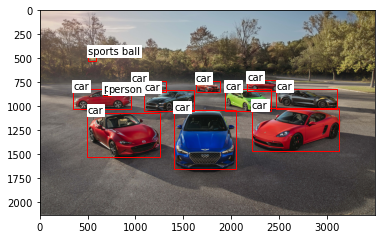

In [49]:
showPreds(img, pred[0], iou_max_overlap=0.15, min_score=0.15, label_names=NAME)